## 3장 평가

* 정확도
: 이진데이터나 불균일한 데이터에서는 많이 활용하지 않는다.>  성능을 왜곡할 수도 있다.

* 타이타닉 데이터에서 성능왜곡: 학습시키지 않고 전부다 하나로 통일시켜도 성능이 높게 나온다

In [1]:
from sklearn.base import BaseEstimator
import numpy as np


#객체 만들기: 학습을 하지 않고 성별에 따라 생존자 예측
class MyDummyClassifier(BaseEstimator):
    #fit에서 학습하지 않음.
    def fit(self, X, y=None):
        pass
    #predict 메서드는 sex가 1이면 0, 그렇지 않으면 1로 예측함
    def predict(self, X):
        pred=np.zeros((X.shape[0],1))
        for i in range(X.shape[0]):
            if X['Sex'].iloc[i]==1:
                pred[i]=0
            else:
                pred[i]=1
        return pred

In [2]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Null 처리 함수
def fillna(df):
    df['Age'].fillna(df['Age'].mean(),inplace=True)
    df['Cabin'].fillna('N',inplace=True)
    df['Embarked'].fillna('N',inplace=True)
    df['Fare'].fillna(0,inplace=True)
    return df

# 머신러닝 알고리즘에 불필요한 속성 제거
def drop_features(df):
    df.drop(['PassengerId','Name','Ticket'],axis=1,inplace=True)
    return df

# 레이블 인코딩 수행. 
def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin','Sex','Embarked']
    for feature in features:
        le = LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df

# 앞에서 설정한 Data Preprocessing 함수 호출
def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

In [3]:
#타이타닉 데이터 전처리
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

titanic_df=pd.read_csv('titanic_train.csv')
y_titanic_df=titanic_df['Survived']
X_titanic_df=titanic_df.drop('Survived', axis=1)
X_titanic_df=transform_features(X_titanic_df)
X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=0.2, random_state=0)

In [4]:
myclf=MyDummyClassifier()
myclf.fit(X_train, y_train)

mypredictions=myclf.predict(X_test)
print('Dummy Classifier의 정확도는: {0:.4f}'.format(accuracy_score(y_test, mypredictions)))

Dummy Classifier의 정확도는: 0.7877


* 불균일한 데이터에서도 하나도 통일시키면 성능이 높게나온다.

In [5]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

class MyFakeClassifier(BaseEstimator):
    def fit(self, X, y):
        pass
    
    #입력값으로 들어오는 X데이터 세트의 크기만큼 모두 0값으로 만들어서 반환
    def predict(self, X):
        return np.zeros( (len(X),1), dtype=bool)
    
#사이킷런 내장 데이터 세트인 load_digits()를 이용해 MNIST 데이터 로딩
digits=load_digits()
    
#digits 번호가 7번이면 True이고 이를 astype(int)로 1로 변환, 7번이 아니면 False이고 0으로 변환
y=(digits.target==7).astype(int)
X_train, X_test, y_train, y_test=train_test_split(digits.data, y, random_state=11)

In [6]:
#불균형한 레이블 데이터 분포도 확인.
print('레이블 테스트 세트 크기:', y_test.shape)
print('테스트 세트 레이블 0과 1의 분포도')
print(pd.Series(y_test).value_counts())

#Dummy Classifier로 학습/예측/정확도 평가
fakeclf=MyFakeClassifier()
fakeclf.fit(X_train, y_train)
fakepred=fakeclf.predict(X_test)
print('모든 예측을 0으로 하여도 정확도는: {:.3f}'.format(accuracy_score(y_test, fakepred)))

레이블 테스트 세트 크기: (450,)
테스트 세트 레이블 0과 1의 분포도
0    405
1     45
dtype: int64
모든 예측을 0으로 하여도 정확도는: 0.900


## 오차행렬
: 이진분류의 예측 오류가 얼마인지와 더불어 어떠한 유형의 예측 오류가 발생하고 있는지 함께 나타냄.(p.173참조)


In [7]:
#오차행렬을 구할 수 있는 confusion_matrix() API
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, fakepred)

#이 경우 전부 negative라고 예측했기 때문에 한쪽으로 모임.positive는 예측하지 않음.

array([[405,   0],
       [ 45,   0]], dtype=int64)

<정밀도와 재현율>
* 정밀도: TP/(FP+TP) : positive로 예측한 대상 중 진짜 positive인 경우 --> positive인걸 negative라고 분류하더라도 상관 없는경우--> precision_score()
* 재현율: TP/(FN+TP) : 진짜 positive인 것 중 positive으로 예측한 경우--> positive을 negative로 잘못 판단하는 경우 재현율 낮음. --> recall_score()

In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

#오차 행렬, 정밀도, 재현율, 정확도를 한번에 반환해주는 함수 만든다.

def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    print('오차행렬')
    print(confusion)
    print('정확도 : {:.4f}\n정밀도 : {:.4f}\n재현율 : {:.4f}'.format(accuracy, precision, recall))

In [9]:
#로지스틱 회귀 기반으로 타이타닉 생존자 예측 후 평가 수행
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

titanic_df=pd.read_csv('titanic_train.csv')
y_titanic_df=titanic_df['Survived']
X_titanic_df=titanic_df.drop('Survived', axis=1)
X_titanic_df=transform_features(X_titanic_df)
X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=0.20, random_state=11)

lr_clf=LogisticRegression(max_iter=500)  #반복수 늘리면 오류 안남

lr_clf.fit(X_train, y_train)
pred=lr_clf.predict(X_test)
get_clf_eval(y_test, pred)

오차행렬
[[104  14]
 [ 13  48]]
정확도 : 0.8492
정밀도 : 0.7742
재현율 : 0.7869


## 정밀도/재현율 트레이드오프
* 이진분류에서 임계값을 기준으로 예측:
pred_proba()이용하여 각 피처 레코드의 개별 클래스 예측 확률을 반환한다.

In [10]:
pred_proba=lr_clf.predict_proba(X_test)
pred=lr_clf.predict(X_test)
print('pred_proba()결과 Shape: {0}'.format(pred_proba.shape))
print('pred_proba array에서 앞 3개만 샘플로 추출 \n:', pred_proba[:3])

#예측 확률 array와 예측 결괏값 array를 병합하여 예측확률과 결과값을 한눈에 확인
pred_proba_result=np.concatenate([pred_proba, pred.reshape(-1,1)], axis=1)
print('두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측\n', pred_proba_result[:3])

pred_proba()결과 Shape: (179, 2)
pred_proba array에서 앞 3개만 샘플로 추출 
: [[0.46228984 0.53771016]
 [0.87873308 0.12126692]
 [0.8772212  0.1227788 ]]
두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측
 [[0.46228984 0.53771016 1.        ]
 [0.87873308 0.12126692 0.        ]
 [0.8772212  0.1227788  0.        ]]


* 임계값을 변환시키면서 정밀도/재현율의 트레이드오프 방식 보기: Binarizer 클래스 이용

In [11]:
from sklearn.preprocessing import Binarizer

X=[[1, -1, 2], 
  [2, 0, 0],
  [0, 1.1, 1.2]]

#X의 개별 원소들이 threshold값보다 같거나 작으면 0을, 크면 1을 반환
binarizer=Binarizer(threshold=1.1)
print(binarizer.fit_transform(X))

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [12]:
#예측함수를 Binarizer클래스를 이용하여 predict() 구현하기
from sklearn.preprocessing import Binarizer

custom_threshold=0.5

#predict_proba() 반환값의 두번째 칼럼, 즉 positive 클래스 칼럼 하나만 추출해 Binarizer를 적용
pred_proba_1=pred_proba[:,1].reshape(-1,1)

binarizer=Binarizer(threshold=custom_threshold).fit(pred_proba_1)  #데이터가 변환되지는 않지만 각 정보를 갖고 있다.(return fitted transfomer 객체가 반환)
custom_predict=binarizer.transform(pred_proba_1)  #0이나 1로 변환한다.

get_clf_eval(y_test, custom_predict)

오차행렬
[[104  14]
 [ 13  48]]
정확도 : 0.8492
정밀도 : 0.7742
재현율 : 0.7869


In [13]:
# Binarizer의 threshold 값을 0.4로 설정
custom_threshold = 0.4

# predict_proba() 결과 값의 두 번째 컬럼, 즉 Positive 클래스의 컬럼 하나만 추출하여 Binarizer를 적용
pred_proba_1 = pred_proba[:,1].reshape(-1,1)

binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

# 임계값을 낮추면 positive로 예측하는 것이 많아지기 때문에 재현율이 올라가고 정밀도가 떨어짐.

오차행렬
[[98 20]
 [10 51]]
정확도 : 0.8324
정밀도 : 0.7183
재현율 : 0.8361


In [14]:
#여러개 임계값 놓고 비교
thresholds=[0.4, 0.45, 0.5, 0.55, 0.6]

def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
    for custom_threshold in thresholds:
        binarizer=Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
        custom_predict=binarizer.transform(pred_proba_c1)
        print('임계값:', custom_threshold)
        get_clf_eval(y_test, custom_predict)
        
get_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1,1), thresholds)

임계값: 0.4
오차행렬
[[98 20]
 [10 51]]
정확도 : 0.8324
정밀도 : 0.7183
재현율 : 0.8361
임계값: 0.45
오차행렬
[[103  15]
 [ 12  49]]
정확도 : 0.8492
정밀도 : 0.7656
재현율 : 0.8033
임계값: 0.5
오차행렬
[[104  14]
 [ 13  48]]
정확도 : 0.8492
정밀도 : 0.7742
재현율 : 0.7869
임계값: 0.55
오차행렬
[[109   9]
 [ 15  46]]
정확도 : 0.8659
정밀도 : 0.8364
재현율 : 0.7541
임계값: 0.6
오차행렬
[[112   6]
 [ 16  45]]
정확도 : 0.8771
정밀도 : 0.8824
재현율 : 0.7377


In [15]:
#정밀도 재현율을 간단한 함수로 표현하기: precision_recall_curve()
from sklearn.metrics import precision_recall_curve

#레이블 값이 1일 때의 예측 확률을 추출
pred_proba_class1=lr_clf.predict_proba(X_test)[:,1]

#실제값 데이터 세트와 레이블 값이 1일 때의 예측 확률을 precision_recall_curve 인자로 입력
precisions, recalls, thresholds= precision_recall_curve(y_test, pred_proba_class1)
print('반환된 분류 결정 임계값 배열의 shape:', thresholds.shape)

#반환된 임계값 배열 로우가 147건이므로 샘플로 10건만 추출하되, 임계값을 15step으로 추출
thr_index=np.arange(0, thresholds.shape[0], 15)
print('샘플 추출을 위한 임계깞 배열의 index 10개: ', thr_index)
print('샘플용 10개의 임계값: ', np.round(thresholds[thr_index],2))

#15step 단위로 추출된 임계값에 따른 정밀도와 재현율 값
print('샘플 임계값별 정밀도: ', np.round(precisions[thr_index], 3))
print('샘플 임계값별 재현율: ', np.round(recalls[thr_index], 3))

반환된 분류 결정 임계값 배열의 shape: (143,)
샘플 추출을 위한 임계깞 배열의 index 10개:  [  0  15  30  45  60  75  90 105 120 135]
샘플용 10개의 임계값:  [0.1  0.12 0.14 0.19 0.28 0.4  0.56 0.67 0.82 0.95]
샘플 임계값별 정밀도:  [0.389 0.44  0.466 0.539 0.647 0.729 0.836 0.949 0.958 1.   ]
샘플 임계값별 재현율:  [1.    0.967 0.902 0.902 0.902 0.836 0.754 0.607 0.377 0.148]


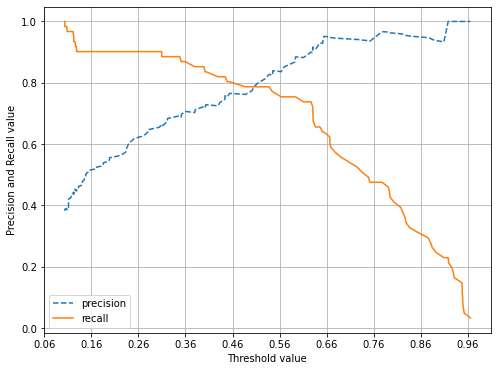

In [16]:
#정밀도와 재현율 시각화
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test, pred_proba_c1):
    #threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray추출.
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    #X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 plot수행. 정밀도 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary=thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')
    
    #threshold 값 X축의 Scale을 0.1 단위로 변경
    start, end=plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    
    #X축, Y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()
    
precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:,1])

## F1 스코어
- 정밀도와 재현율을 결합: F1 스코어가 높을수록 균형이 좋음.

In [17]:
from sklearn.metrics import f1_score
f1=f1_score(y_test, pred)  #f1_score함수 이용해서 구할 수있음.
print('F1 스코어: {0:.4f}'.format(f1))

F1 스코어: 0.7805


In [18]:
#임계값을 변화시키면서 F1스코어의 변화보기
def get_clf_eval(y_test, pred):
    confusion=confusion_matrix(y_test, pred)
    accuracy=accuracy_score(y_test, pred)
    precision=precision_score(y_test, pred)
    recall=recall_score(y_test, pred)
    
    #F1 스코어 추가
    f1=f1_score(y_test, pred)
    print('오차행렬')
    print(confusion)
    
    #f1 score print 추가
    print('정확도: {0:.4f}, 정밀도:{1:.4f}, 재현율: {2:.4f}, F1:{3:.4f}'.format(accuracy, precision, recall, f1))
    
thresholds=[0.4, 0.45, 0.5, 0.55, 0.6]
pred_proba=lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), thresholds)

임계값: 0.4
오차행렬
[[98 20]
 [10 51]]
정확도: 0.8324, 정밀도:0.7183, 재현율: 0.8361, F1:0.7727
임계값: 0.45
오차행렬
[[103  15]
 [ 12  49]]
정확도: 0.8492, 정밀도:0.7656, 재현율: 0.8033, F1:0.7840
임계값: 0.5
오차행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도:0.7742, 재현율: 0.7869, F1:0.7805
임계값: 0.55
오차행렬
[[109   9]
 [ 15  46]]
정확도: 0.8659, 정밀도:0.8364, 재현율: 0.7541, F1:0.7931
임계값: 0.6
오차행렬
[[112   6]
 [ 16  45]]
정확도: 0.8771, 정밀도:0.8824, 재현율: 0.7377, F1:0.8036


## ROC 곡선과 AUC

In [19]:
from sklearn.metrics import roc_curve

#레이블 값이 1일 때의 예측 확률을 추출
pred_proba_class1=lr_clf.predict_proba(X_test)[:,1]

fprs, tprs, thresholds= roc_curve(y_test, pred_proba_class1)
#반환된 임계값 배열 로우가 47건이므로 샘플로 10건만 추출, 임계값을 5step으로 추출
#thresholds[0]은 max(예측확률)+1로 임의 설정됨. 이를 제외하기 위해 np.arange는 1부터 시작

thr_index=np.arange(1, thresholds.shape[0], 5)
print('샘플 추출을 위한 임계값 배열의 index 10개: ', thr_index)
print('샘플용 10개의 임계값: ', np.round(thresholds[thr_index],2))

#5 step 단위로 추출된 임계값에 따른 FPR, TPR값
print('샘플 임계값별 FPR: ', np.round(fprs[thr_index],3))
print('샘플 임계값별 TPR: ', np.round(tprs[thr_index],3))

샘플 추출을 위한 임계값 배열의 index 10개:  [ 1  6 11 16 21 26 31 36 41 46 51]
샘플용 10개의 임계값:  [0.97 0.65 0.63 0.56 0.45 0.4  0.35 0.15 0.13 0.11 0.11]
샘플 임계값별 FPR:  [0.    0.017 0.034 0.076 0.127 0.169 0.203 0.466 0.585 0.686 0.797]
샘플 임계값별 TPR:  [0.033 0.639 0.721 0.754 0.803 0.836 0.885 0.902 0.934 0.967 0.984]


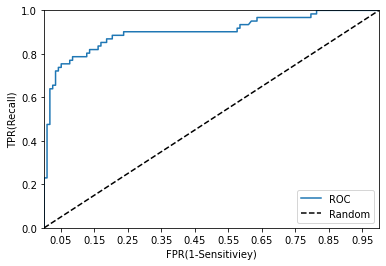

In [20]:
#roc curve 시각화
def roc_curve_plot(y_test, pred_proba_c1):
    #임계값에 따른 FPR, TPR 값을 반환받음.
    fprs, tprs, thresholds= roc_curve(y_test, pred_proba_c1)
    #ROC 곡선을 그래프 곡선으로 그림.
    plt.plot(fprs, tprs, label='ROC')
    #가운데 대각선 직선을 그림.
    plt.plot([0,1], [0,1], 'k--', label='Random')
    
    #FPR X축의 Scale을 0.1단위로 변경, X, Y축 명 설정 등
    start, end=plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    plt.xlim(0,1); plt.ylim(0,1)
    plt.xlabel('FPR(1-Sensitiviey)'); plt.ylabel('TPR(Recall)')
    plt.legend()
    
roc_curve_plot(y_test, pred_proba[:,1])

In [21]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
from sklearn.metrics import recall_score, f1_score, roc_auc_score
import numpy as np

print(confusion_matrix(y_test, pred))
print("정확도:", np.round(accuracy_score(y_test, pred),4))
print("정밀도:", np.round(precision_score(y_test, pred),4))
print("재현율:", np.round(recall_score(y_test, pred),4))

[[104  14]
 [ 13  48]]
정확도: 0.8492
정밀도: 0.7742
재현율: 0.7869


In [22]:
# ROC, AUC 추가
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion=confusion_matrix(y_test, pred)
    accuracy=accuracy_score(y_test, pred)
    precision=precision_score(y_test, pred)
    recall=recall_score(y_test, pred)
    f1=f1_score(y_test, pred)
    
    #ROC, AUC 추가
    roc_auc=roc_auc_score(y_test, pred_proba)
    print('오차행렬')
    print(confusion)
    
    #ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도:{1:.4f}, 재현율: {2:.4f}, F1:{3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

## 피마 인디언 당뇨병 예측

In [23]:
#필요한 모듈 임포트
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [24]:
diabetes_data=pd.read_csv('diabetes.csv')
print(diabetes_data['Outcome'].value_counts())
diabetes_data.head(3)

0    500
1    268
Name: Outcome, dtype: int64


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1


In [25]:
#feature의 타입과 Null개수
diabetes_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [26]:
#예측모델 생성

#데이터 분리
#피쳐 데이터 세트 X, 레이블 데이터 세트 y를 추출.
#맨 끝이 Outcome 칼럼으로 레이블 값임. 칼럼 위치 -1을 이용해 추출
X=diabetes_data.iloc[:,:-1]
y=diabetes_data.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=156, stratify=y)  #계층적 데이터 추출

#로지스틱 회귀로 학습, 예측 및 평가 수행.
lr_clf=LogisticRegression()
lr_clf.fit(X_train, y_train)
pred=lr_clf.predict(X_test)
pred_proba=lr_clf.predict_proba(X_test)[:,1]

get_clf_eval(y_test, pred, pred_proba)

오차행렬
[[88 12]
 [23 31]]
정확도: 0.7727, 정밀도:0.7209, 재현율: 0.5741, F1:0.6392, AUC:0.7919


C:\Users\Seowoo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


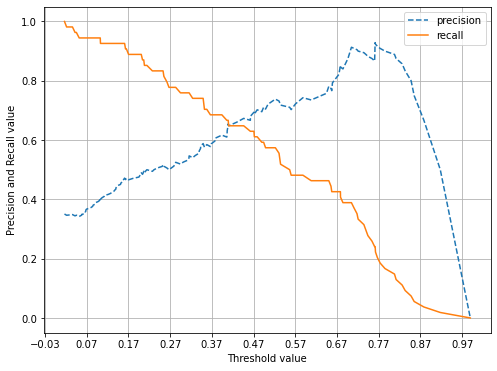

In [27]:
#임계값별 정밀도와 재현율 값의 변화
pred_proba_c1=lr_clf.predict_proba(X_test)[:,1]
precision_recall_curve_plot(y_test, pred_proba_c1)

In [28]:
#임계값을 균형이 맞는 0.42로 한다고 해도 각각의 수치가 높지 않다. 따라서 다시 데이터 값을 점검한다.
diabetes_data.describe()
#데이터에 0인 값이 많다. 특히 포도당 치수가 0인건 말이 안된다.

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


(array([  5.,   0.,   4.,  32., 156., 211., 163.,  95.,  56.,  46.]),
 array([  0. ,  19.9,  39.8,  59.7,  79.6,  99.5, 119.4, 139.3, 159.2,
        179.1, 199. ]),
 <BarContainer object of 10 artists>)

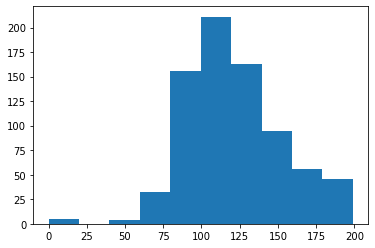

In [29]:
plt.hist(diabetes_data['Glucose'], bins=10)

In [30]:
#min()값이 0으로 되어있는 피처에 대해 0 값의 건수, 전체 데이터 건수 대비 어느정도 비율로 존재하는지 파악
#0값을 검사할 피처명 리스드
zero_features=['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

#전체 데이터 건수
total_count=diabetes_data['Glucose'].count()

#피처별로 반복하면더 데이터 값이 0인 데이터 건수를 추출하고, 퍼센트 계산
for feature in zero_features:
    zero_count=diabetes_data[diabetes_data[feature]==0][feature].count()
    print('{0} 0 건수는 {1}, 퍼센트는 {2:.2f} %'.format(feature, zero_count, 100*zero_count/total_count))

Glucose 0 건수는 5, 퍼센트는 0.65 %
BloodPressure 0 건수는 35, 퍼센트는 4.56 %
SkinThickness 0 건수는 227, 퍼센트는 29.56 %
Insulin 0 건수는 374, 퍼센트는 48.70 %
BMI 0 건수는 11, 퍼센트는 1.43 %


In [31]:
#0인 데이터를 모두 삭제하기에는 너무 많기 떄문에 평균값으로 대체한다.
mean_zero_features=diabetes_data[zero_features].mean()
diabetes_data[zero_features]=diabetes_data[zero_features].replace(0,mean_zero_features)

In [32]:
#다시 학습: 피처 스케일링을 이용해 적용한다.
X=diabetes_data.iloc[:,:-1]
y=diabetes_data.iloc[:,-1]

#StandartScaler 클래스를 이용해 피처 데이터 세트에 일괄적으로 스케일링 적용
scaler=StandardScaler()
X_scaled=scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=156, stratify=y)  #계층적 데이터 추출

#로지스틱 회귀로 학습, 예측 및 평가 수행.
lr_clf=LogisticRegression()
lr_clf.fit(X_train, y_train)
pred=lr_clf.predict(X_test)
pred_proba=lr_clf.predict_proba(X_test)[:,1]

get_clf_eval(y_test, pred, pred_proba)

오차행렬
[[90 10]
 [21 33]]
정확도: 0.7987, 정밀도:0.7674, 재현율: 0.6111, F1:0.6804, AUC:0.8433


In [33]:
# 성능이 좋아졌지만 재현율 수치가 개선이 필요해보임. 
# 임계값을 변화시키면서 다시 확인
def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
    for custom_threshold in thresholds:
        binarizer=Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
        custom_predict=binarizer.transform(pred_proba_c1)
        print('임계값:', custom_threshold)
        get_clf_eval(y_test, custom_predict, pred_proba_c1)


thresholds=[0.3,0.33,0.36,0.39,0.42,0.45,0.48,0.5]
pred_proba=lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), thresholds )

임계값: 0.3
오차행렬
[[67 33]
 [11 43]]
정확도: 0.7143, 정밀도:0.5658, 재현율: 0.7963, F1:0.6615, AUC:0.8433
임계값: 0.33
오차행렬
[[72 28]
 [12 42]]
정확도: 0.7403, 정밀도:0.6000, 재현율: 0.7778, F1:0.6774, AUC:0.8433
임계값: 0.36
오차행렬
[[76 24]
 [15 39]]
정확도: 0.7468, 정밀도:0.6190, 재현율: 0.7222, F1:0.6667, AUC:0.8433
임계값: 0.39
오차행렬
[[78 22]
 [16 38]]
정확도: 0.7532, 정밀도:0.6333, 재현율: 0.7037, F1:0.6667, AUC:0.8433
임계값: 0.42
오차행렬
[[84 16]
 [18 36]]
정확도: 0.7792, 정밀도:0.6923, 재현율: 0.6667, F1:0.6792, AUC:0.8433
임계값: 0.45
오차행렬
[[85 15]
 [18 36]]
정확도: 0.7857, 정밀도:0.7059, 재현율: 0.6667, F1:0.6857, AUC:0.8433
임계값: 0.48
오차행렬
[[88 12]
 [19 35]]
정확도: 0.7987, 정밀도:0.7447, 재현율: 0.6481, F1:0.6931, AUC:0.8433
임계값: 0.5
오차행렬
[[90 10]
 [21 33]]
정확도: 0.7987, 정밀도:0.7674, 재현율: 0.6111, F1:0.6804, AUC:0.8433


In [34]:
#임계값을 0.48로 설정한 Binarizer 생성
binarizer=Binarizer(threshold=0.48)

#위에서 구한 lr_clf의 predict_proba() 예측 확률array에서 1에 해당하는 칼럼값을 Binarizer 변환.
pred_th_048=binarizer.fit_transform(pred_proba[:,1].reshape(-1,1))

get_clf_eval(y_test, pred_th_048, pred_proba[:,1])

오차행렬
[[88 12]
 [19 35]]
정확도: 0.7987, 정밀도:0.7447, 재현율: 0.6481, F1:0.6931, AUC:0.8433
